In [1]:
import numpy as np
import scipy.constants as sciconst
import matplotlib.pyplot as plt
import navicsim as navs


## Simulation constants 

In [2]:
codeFreqBasis = 1.023e6
sampleRate = 10*codeFreqBasis
samplePeriod = 1/sampleRate

simDuration = 10 #48 sec for 2400 symbols #in Seconds
timeStep = 1e-3
numSteps = round(simDuration/timeStep)
samplePerStep = int(timeStep/samplePeriod)

codeTable = navs.genNavicCaTable(sampleRate)
codeTableSampCnt = len(codeTable)
satId = np.array([5, 7, 3, 1])
numChannel = len(satId)

In [3]:
c = sciconst.speed_of_light
fe = 1176.45e6;              
Dt = 12;                     
DtLin = 10*np.log10(Dt)
Dr = 4;                      
DrLin = 10*np.log10(Dr)
Pt = 44.8;                   
k = sciconst.Boltzmann;  
T = 315;                     
rxBW = 40e6;                 
Nr = k*T*rxBW;               

In [4]:
PLLIntegrationTime = 1e-3
PLLNoiseBandwidth = 90 # In Hz
FLLNoiseBandwidth = 4  # In Hz
DLLNoiseBandwidth = 1  # In Hz

## Channel configuration

In [5]:
fShift = np.array([3589, 2256, 1596, 2568])
channelpfo = navs.PhaseFrequencyOffset(sampleRate)

sigDelay = np.array([300.34, 587.21, 425.89, 312.88])
dynamicDelayRange = 50
staticDelay = np.round(sigDelay - dynamicDelayRange)
channelstatd = navs.IntegerDelay(staticDelay)
channelvard = navs.FractionalDelay(4, 65535)

sqrtPr = np.sqrt(Pt*DtLin*DrLin)*(1/(4*np.pi*(fe+fShift)*sigDelay*samplePeriod))

## Run Simulation

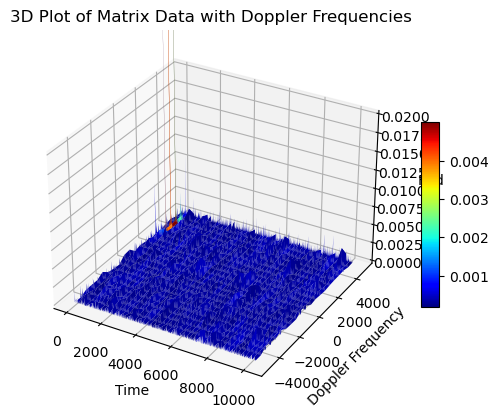

Acquisition results for PRN ID 5
 Status:True Doppler:3500 Delay/Code-Phase:300/30.0


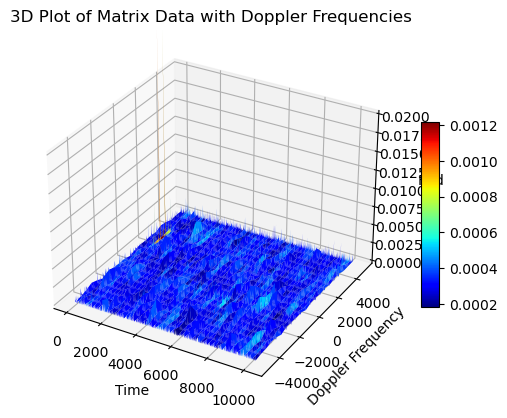

Acquisition results for PRN ID 7
 Status:True Doppler:2000 Delay/Code-Phase:587/58.7


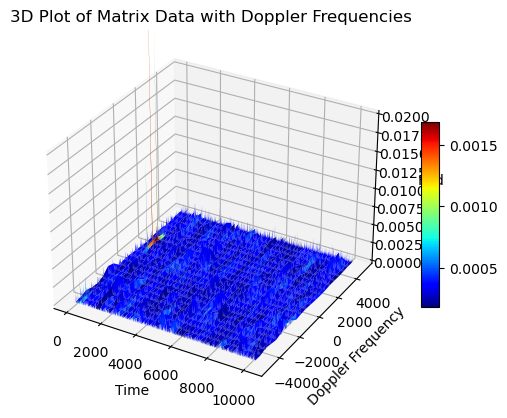

Acquisition results for PRN ID 3
 Status:True Doppler:1500 Delay/Code-Phase:426/42.6


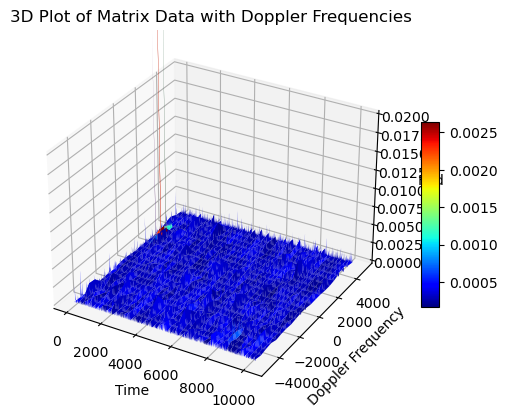

Acquisition results for PRN ID 1
 Status:True Doppler:2500 Delay/Code-Phase:313/31.3


KeyboardInterrupt: 

In [6]:
datagen = navs.NavicDataGen(50, sampleRate, numChannel)
modulator = navs.NavicL5sModulator(sampleRate)

rms = lambda x: np.sqrt(np.mean(np.abs(x)**2, axis=0)) 

for istep in range(numSteps):
    
    # Baseband modulation
    navdata = datagen.GenerateBits(timeStep)
    
    iqsig = modulator.Modulate(navdata, codeTable[:, satId-1])

    # Doppler shift
    doppsig = channelpfo.Offset(iqsig, fShift)

    # Delay
    staticDelayedSignal = channelstatd.Delay(doppsig)
    leftoutDelay = sigDelay - staticDelay
    delayedSig = channelvard.Delay(staticDelayedSignal, leftoutDelay)

    # Power scaling
    scaledSig = navs.PowerScale(delayedSig, sqrtPr)

    # Add signals from each channel
    resultsig = np.sum(scaledSig, axis=1)

    # Generate noise
    noisesig = (np.random.normal(scale=Nr**0.5, size=(samplePerStep, )) + 1j*np.random.normal(scale=Nr**0.5, size=(samplePerStep, )))/2**0.5

    # Add thermal noise to composite signal
    rxwaveform = resultsig + noisesig

    # Scale received signal to have unit power
    waveform = rxwaveform/rms(rxwaveform)  

    # Perform acquisition once from cold-start
    if istep == 0:
        # Acqusition doppler search space
        fMin = -5000
        fMax = 5000
        fStep = 500
        fSearch = np.arange(fMin, fMax+fStep, fStep)

        tracker = []
        satVis = 0
        # Perform acquisition for each satellite
        for prnId in satId:
            status, codePhase, doppler = navs.navic_pcps_acquisition(
                                            waveform, 
                                            codeTable[np.arange(0, samplePerStep)%codeTableSampCnt, prnId-1], 
                                            sampleRate, 
                                            fSearch
                                        )   
            delaySamp = codePhase
            codePhase = (codePhase % codeTableSampCnt)/(sampleRate/codeFreqBasis)

            print(f"Acquisition results for PRN ID {prnId}\n Status:{status} Doppler:{doppler} Delay/Code-Phase:{delaySamp}/{codePhase}")

            # If a satellite is visible, initialize tracking loop
            if(status == True):
                satVis += 1

                tracker.append(navs.NavicTracker())
                tracker[-1].SampleRate = sampleRate
                tracker[-1].CenterFrequency = 0
                tracker[-1].PLLNoiseBandwidth = PLLNoiseBandwidth
                tracker[-1].FLLNoiseBandwidth = FLLNoiseBandwidth
                tracker[-1].DLLNoiseBandwidth = DLLNoiseBandwidth
                tracker[-1].PLLIntegrationTime = round(PLLIntegrationTime*1e3)
                tracker[-1].PRNID = prnId
                tracker[-1].InitialDopplerShift = doppler
                tracker[-1].InitialCodePhaseOffset = codePhase
                tracker[-1].setupImpl()
                tracker[-1].resetImpl()

            trackDataShape = (numSteps*round(PLLIntegrationTime*1e3), satVis)
            y = np.empty(trackDataShape, dtype=np.complex_)
            fqyerr = np.empty(trackDataShape)
            fqynco = np.empty(trackDataShape)
            pherr = np.empty(trackDataShape)
            phnco = np.empty(trackDataShape)
            delayerr = np.empty(trackDataShape)
            delaynco = np.empty(trackDataShape)

    # Perform tracking for visible satellites
    for i in range(satVis):
      y[istep, i], fqyerr[istep, i], fqynco[istep, i], pherr[istep, i], phnco[istep, i], delayerr[istep, i], delaynco[istep, i] = tracker[i].stepImpl(waveform)




plt.subplot(6,1,1)
plt.plot(fqyerr)
#plt.ylim([0,0.05])
plt.xlabel('time') ; plt.ylabel('Fqy Error')
    
plt.subplot(6,1,2)
plt.plot(fqynco[:,i])
#plt.ylim([0,0.05])
plt.xlabel('time') ; plt.ylabel('Fqy NCO')

plt.subplot(6,1,3)
plt.plot(pherr[:,i])
#plt.ylim([0,0.05])
plt.xlabel('time') ; plt.ylabel('Phase Error')

plt.subplot(6,1,4)
plt.plot(phnco[:,i])
#plt.ylim([0,0.05])
plt.xlabel('time') ; plt.ylabel('Phase NCO')

plt.subplot(6,1,5)
plt.plot(delayerr[:,i])
#plt.ylim([0,0.05])
plt.xlabel('time') ; plt.ylabel('Delay Error')
    
plt.subplot(6,1,6)
plt.plot(delaynco[:,i])
#plt.ylim([0,0.05])
plt.xlabel('time') ; plt.ylabel('Delay NCO')




## Bit and Frame Synchronization

In [ ]:
for i in range(satVis):
    n = 20 #Number of data per bit
    skip = 2 #Forgo few bits as the tracking loops starts early
    k = np.imag(y[n*skip:,i])
    sync_index, num_tr = navs.gnss_bit_synchronize(k, n)
    print("Synchronization index:", sync_index)

    l = np.mean(k[sync_index:(((len(k)-sync_index)//n) * n) + sync_index].reshape(-1,n).T, axis=0)
    mapbits = lambda l: np.piecewise(l, [l < 0, l >= 0], [1, 0])
    bits = mapbits(l)
    status, fsync_index = navs.find_sync_word(bits)

    print("Frame Sync status:", status)
    print("Frame Sync:", fsync_index)
    if status == -1:
        bits = 1*np.logical_not(bits)
    
    sync_frames = bits[fsync_index:]
    num_sf = len(sync_frames)//600
    check = navs.decoder(sync_frames[0:num_sf*600].reshape(-1,600),num_sf).reshape(-1,286)
    navbits = datagen.GetBitStream()[292:292+num_sf*292,i].reshape(-1,292)
    for j in range(num_sf):
        if(np.array_equal(check[j], navbits[j,:-6])):
            print("Equal")
        else:
            print("Not Equal")

TypeError: cannot unpack non-iterable numpy.uint16 object